<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Multi_layer_LSTM_for_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

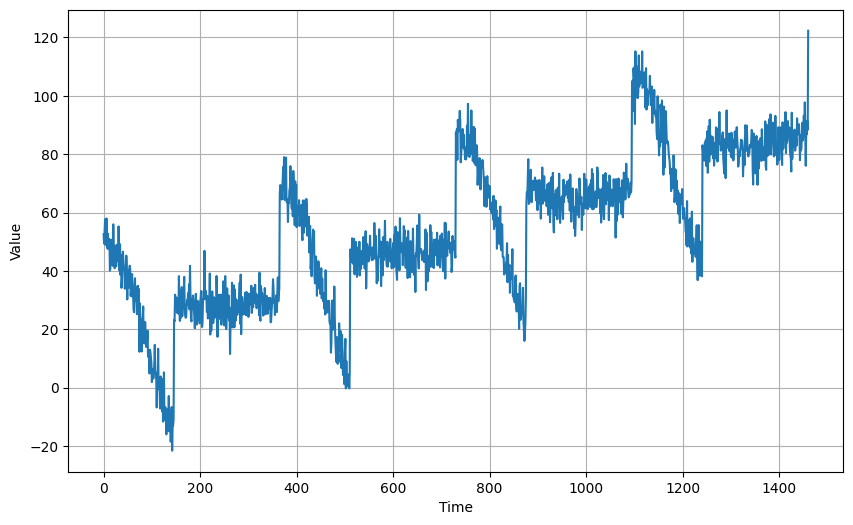

In [43]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [44]:
# Split the dataset
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = time[split_time:]

In [45]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [46]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1,shift = 1,drop_remainder = True)

  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))

  dataset = dataset.map(lambda window : (window[:-1],window[-1]))

  dataset = dataset.shuffle(shuffle_buffer)

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [47]:
# Generate the dataset windows
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [48]:
# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x : tf.expand_dims(x,axis = -1),
        input_shape = [window_size]
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100)
])

model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 20, 64)            8704      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 3360

In [49]:
# Tune the learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(
    momentum = 0.9
)

# Set the training parameters
model_tune.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
)

# Train the model
history = model_tune.fit(
    dataset,
    epochs = 100,
    callbacks = [lr_schedule]
)

Epoch 1/100
31/31 [==============================] - 10s 31ms/step - loss: 13.4033 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 13.2283 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 2s 45ms/step - loss: 13.0430 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 12.8449 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 12.6475 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 12.4408 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 34ms/step - loss: 12.2351 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 32ms/step - loss: 12.0199 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 32ms/step - loss: 11.8027 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 30ms/step - loss: 11.5708 - lr: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 30.0)

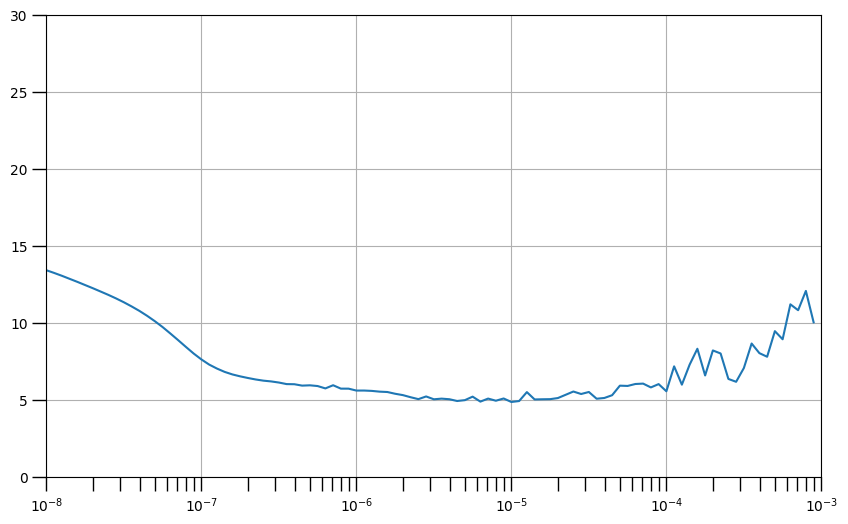

In [50]:
# Define the learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs,history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

In [51]:
# Train the model
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x : tf.expand_dims(x,axis = -1),
        input_shape = [None]
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*100)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate = learning_rate,
    momentum = 0.9
)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

# Train the model
history = model.fit(
    dataset,
    epochs = 100
)

Epoch 1/100
31/31 [==============================] - 8s 33ms/step - loss: 21.3825 - mae: 21.8778
Epoch 2/100
31/31 [==============================] - 1s 29ms/step - loss: 10.1625 - mae: 10.6525
Epoch 3/100
31/31 [==============================] - 2s 53ms/step - loss: 7.6873 - mae: 8.1682
Epoch 4/100
31/31 [==============================] - 1s 29ms/step - loss: 6.9257 - mae: 7.4084
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 6.6559 - mae: 7.1367
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 6.4079 - mae: 6.8896
Epoch 7/100
31/31 [==============================] - 1s 29ms/step - loss: 6.2876 - mae: 6.7697
Epoch 8/100
31/31 [==============================] - 1s 29ms/step - loss: 6.1948 - mae: 6.6796
Epoch 9/100
31/31 [==============================] - 1s 34ms/step - loss: 6.1550 - mae: 6.6366
Epoch 10/100
31/31 [==============================] - 1s 28ms/step - loss: 5.9537 - mae: 6.4336
Epoch 11/100
31/31 [=========================

In [55]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 0s 23ms/step


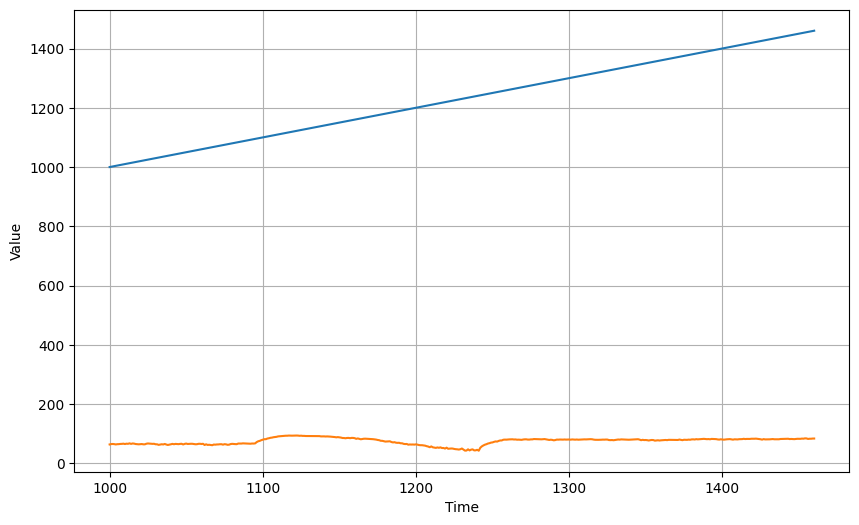

In [57]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [58]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1350650.1
1154.9353
